## Preparing features & labels

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [ ]:
dataset = tf.data.Dataset.range(10)       # dataset object to make values

for val in dataset:
   print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)        # creates window in dataset of each row of 5 items

for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)     # taking only till that row which has 5 values

for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))     # converting each row to list

for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))        # splitting into Xs and y

for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)                               # shuffling the rows

for x,y in dataset:
  print(x.numpy(), y.numpy())

[3 4 5 6] [7]
[1 2 3 4] [5]
[5 6 7 8] [9]
[4 5 6 7] [8]
[0 1 2 3] [4]
[2 3 4 5] [6]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)                                  # taking batch size of 2

for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]
x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [[8]
 [7]]
x =  [[5 6 7 8]
 [1 2 3 4]]
y =  [[9]
 [5]]


## ML on Time Windows

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")                # 1461 records
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# update with noise
series += noise(time, noise_level, seed=42)

In [4]:
SPLIT_TIME = 1000                                             # 1000 training records
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [5]:
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):                      # shuffle_buffer determines how data will be shuffled
  dataset = tf.data.Dataset.from_tensor_slices(series)                                      # creates the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))                  # flatten data in size window_size+1
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))   # shuffled
  dataset = dataset.batch(batch_size).prefetch(1)                                           # batched into batch size and returned
  return dataset

In [8]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [9]:
model = Sequential([
    layers.InputLayer(input_shape=(WINDOW_SIZE)),
    layers.Dense(1, name="l0")
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (Dense)                  (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
loss        = tf.keras.losses.MeanSquaredError()

In [12]:
model.compile(optimizer=optimizer,
              loss=loss)

In [13]:
EPOCHS = 50

In [14]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS)

Epoch 1/50
31/31 [==============================] - 1s 5ms/step - loss: 183.2509
Epoch 2/50
31/31 [==============================] - 0s 4ms/step - loss: 144.5407
Epoch 3/50
31/31 [==============================] - 0s 4ms/step - loss: 119.2143
Epoch 4/50
31/31 [==============================] - 0s 4ms/step - loss: 105.3125
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 96.3288
Epoch 6/50
31/31 [==============================] - 0s 4ms/step - loss: 89.0851
Epoch 7/50
31/31 [==============================] - 0s 4ms/step - loss: 85.3485
Epoch 8/50
31/31 [==============================] - 0s 4ms/step - loss: 82.8831
Epoch 9/50
31/31 [==============================] - 0s 4ms/step - loss: 79.7630
Epoch 10/50
31/31 [==============================] - 0s 4ms/step - loss: 77.7934
Epoch 11/50
31/31 [==============================] - 0s 4ms/step - loss: 76.2672
Epoch 12/50
31/31 [==============================] - 0s 4ms/step - loss: 74.9850
Epoch 13/50
31/31 [==============

In [15]:
print((model.get_layer("l0").weights))

# array 1 shows w1, w2,...w20
# array 2 shows bias

[<tf.Variable 'l0/kernel:0' shape=(20, 1) dtype=float32, numpy=
array([[ 0.07426987],
       [-0.19904943],
       [ 0.02470785],
       [-0.03918562],
       [ 0.16187908],
       [ 0.12198754],
       [-0.11864246],
       [-0.03359067],
       [-0.15147538],
       [ 0.21328077],
       [ 0.05057142],
       [-0.06889593],
       [-0.03969443],
       [-0.04493778],
       [-0.09813479],
       [ 0.14092278],
       [ 0.17628303],
       [ 0.23275587],
       [ 0.14918995],
       [ 0.4313564 ]], dtype=float32)>, <tf.Variable 'l0/bias:0' shape=(1,) dtype=float32, numpy=array([0.00781474], dtype=float32)>]


In [16]:
print(model.layers[0].weights)
print(model.layers[0].bias.numpy())
print(model.layers[0].bias_initializer)

[<tf.Variable 'l0/kernel:0' shape=(20, 1) dtype=float32, numpy=
array([[ 0.07426987],
       [-0.19904943],
       [ 0.02470785],
       [-0.03918562],
       [ 0.16187908],
       [ 0.12198754],
       [-0.11864246],
       [-0.03359067],
       [-0.15147538],
       [ 0.21328077],
       [ 0.05057142],
       [-0.06889593],
       [-0.03969443],
       [-0.04493778],
       [-0.09813479],
       [ 0.14092278],
       [ 0.17628303],
       [ 0.23275587],
       [ 0.14918995],
       [ 0.4313564 ]], dtype=float32)>, <tf.Variable 'l0/bias:0' shape=(1,) dtype=float32, numpy=array([0.00781474], dtype=float32)>]
[0.00781474]


In [17]:
series[:20]

array([52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
       57.982895, 53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374,
       50.959415, 40.086178, 40.919415, 46.612473, 44.228207, 50.720642,
       44.454983, 41.76799 ], dtype=float32)

In [18]:
model.predict(series[:20][np.newaxis])

array([[44.467808]], dtype=float32)

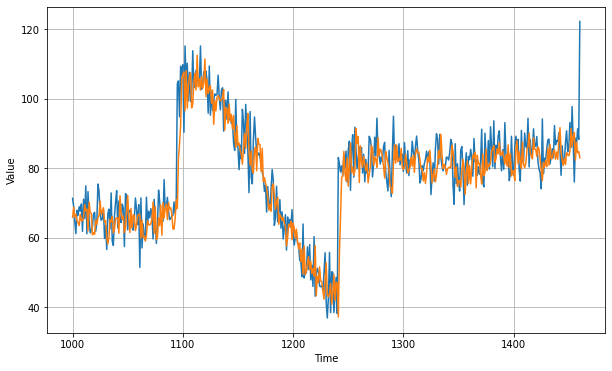

In [19]:
forecast = []

for time in range(len(series) - WINDOW_SIZE):
  forecast.append(model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2794876

## Using DNN to improve

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [22]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [23]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# update with noise
series += noise(time, noise_level, seed=42)

In [24]:
SPLIT_TIME = 1000
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [25]:
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

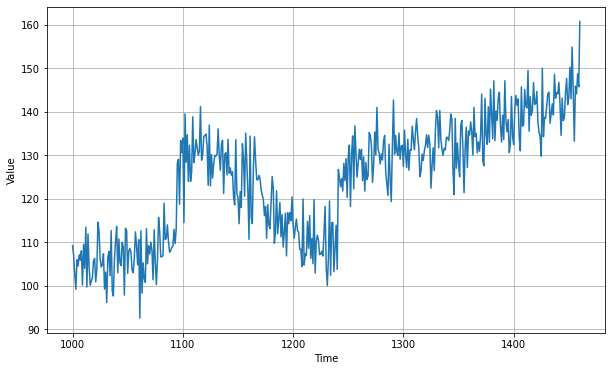

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [28]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [29]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),
    layers.Dense(10, activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [31]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
loss        = tf.keras.losses.MeanSquaredError()

In [32]:
model.compile(optimizer=optimizer,
              loss=loss)

In [33]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [34]:
EPOCHS = 100
CALLBACKS = [early_stopping, model_checkpoint]

In [35]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/100
31/31 [==============================] - 1s 6ms/step - loss: 2355.4297
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 115.5427
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 58.7774
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 54.6399
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 53.6557
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 53.1894
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 53.0537
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 51.6801
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 51.2797
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 50.7558
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 49.4484
Epoch 12/100
31/31 [==============================] - 0s 6ms/step - loss: 48.9419
Epoch 13/100
31/31 [==

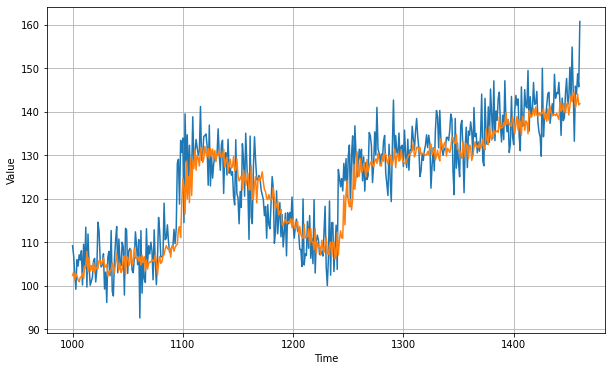

In [36]:
forecast = []

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.845796

## Using DNN with LR Scheduler

In [38]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [39]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),
    layers.Dense(10, activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [41]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.MeanSquaredError()

In [42]:
model.compile(optimizer=optimizer,
              loss=loss)

In [43]:
# using Scheduler to monitor learning_rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(                         # changes LR to a value based on epoch number
    lambda epoch: 1e-8 * 10**(epoch / 20))                                      # eg: for epoch 1 -> 10^-8 * 10^(1/20), for epoch 100 -> 10^-8 * 10^(100/20)

In [44]:
early_stopping    = EarlyStopping(monitor='loss', patience=5)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [45]:
EPOCHS = 100
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [46]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/100
31/31 [==============================] - 1s 7ms/step - loss: 3922.6011 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 2327.2371 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 1518.2523 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 1078.1398 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 732.3820 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 457.4192 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 258.6873 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 140.6669 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 84.6517 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 64.6152 - lr: 2.8184e-08
Epoch 1

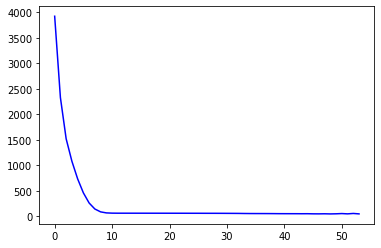

In [47]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

(1e-08, 0.0001, 0.0, 500.0)

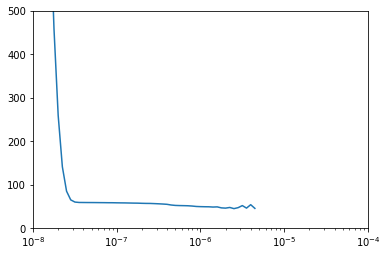

In [49]:
lrs = 1e-8 * (10 ** (np.arange(54) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 500])

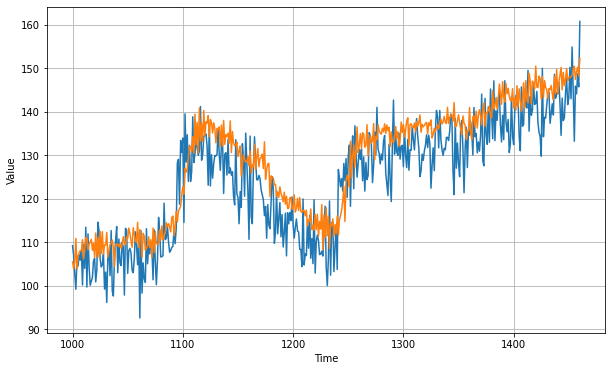

In [50]:
forecast = []

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.0989976

In [52]:
best_model = tf.keras.models.load_model('best_model.h5')

In [53]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


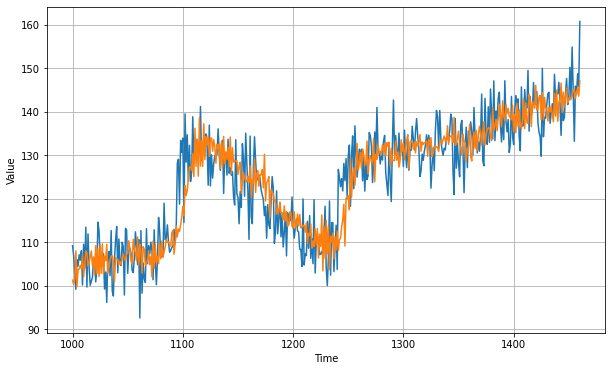

In [54]:
forecast = []

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(best_model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [55]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.019777

## Exercise 14

For this exercise you’ll create your own synthetic dataset -- I’ve plotted a chart for what it should look like, see if you can figure out the parameters that get this series.

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [57]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [58]:
time = np.arange(10 * 365 + 1, dtype="float32")               # 3651 records
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=51)

In [59]:
SPLIT_TIME = 3000
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [60]:
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

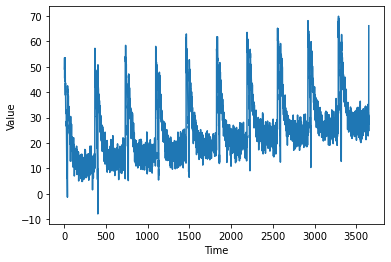

In [61]:
plot_series(time, series)

In [62]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [63]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [64]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),
    layers.Dense(100, activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               2100      
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [66]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
loss        = tf.keras.losses.MeanSquaredError()

In [67]:
model.compile(optimizer=optimizer,
              loss=loss)

In [68]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [69]:
EPOCHS = 100
CALLBACKS = [early_stopping, model_checkpoint]

In [70]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/100
94/94 [==============================] - 1s 9ms/step - loss: 63.5607
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 39.9643
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 34.4973
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 31.9233
Epoch 5/100
94/94 [==============================] - 1s 8ms/step - loss: 29.9918
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 28.6405
Epoch 7/100
94/94 [==============================] - 1s 8ms/step - loss: 27.9446
Epoch 8/100
94/94 [==============================] - 1s 9ms/step - loss: 27.2856
Epoch 9/100
94/94 [==============================] - 1s 9ms/step - loss: 26.7307
Epoch 10/100
94/94 [==============================] - 1s 8ms/step - loss: 26.3311
Epoch 11/100
94/94 [==============================] - 1s 9ms/step - loss: 25.9275
Epoch 12/100
94/94 [==============================] - 1s 8ms/step - loss: 25.7993
Epoch 13/100
94/94 [=====

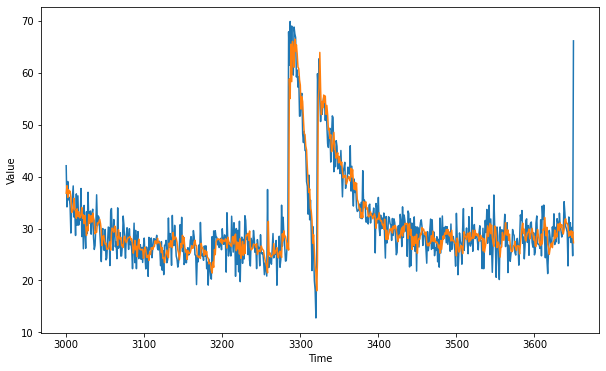

In [71]:
forecast = []

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [72]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.987638